## Imports

In [149]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

## Data loading & cleaning

In [249]:
from helper import clean_data
from helper import vix_prime_combine

In [322]:
vix_close , prime, weekly_vix, monthly_vix = clean_data()

In [323]:
vp_df = vix_prime_combine(monthly_vix,prime) ## combines monthly vix data & monthly prime data

## Look for stationarity of my data with Dicker Fuller test

In [153]:
import statsmodels.tsa.stattools as ts
from helper import dftest

Test Statistic            -5.508621
p-value                    0.000002
Lags Used                 11.000000
Observations Used       7305.000000
Critical Value (1%)       -3.431245
Critical Value (5%)       -2.861936
Critical Value (10%)      -2.566981
dtype: float64


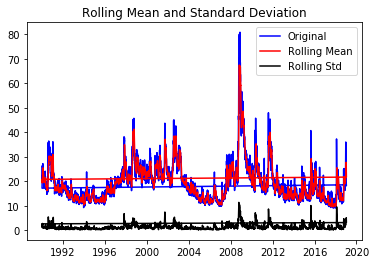

In [154]:
dftest(vix_close.vix_close)

It passed! According to Jonathan I can still try differencing.

## Let's split data up into test and train

In [155]:
from helper import split_data

In [390]:
train, validation, test = split_data(weekly_vix,52)

## Now let's try an AR models

First let's optimize p. I stopped at 15 because it got too slow.

In [391]:
from helper import optimize_ar
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

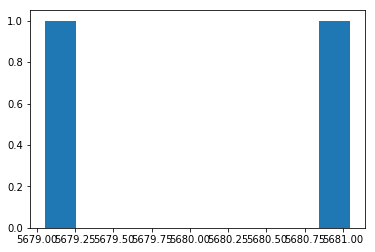

In [392]:
train_ar_params = optimize_ar(train, 3)

Best AIC for AR is 26804.84334590905 at p=12

In [393]:
train_ar_params

(5679.055033817317, 1)

14 says it is the best, but the histogram shows only 20 points decrease from worst, so let's use a simple model which optimizes at p=1.

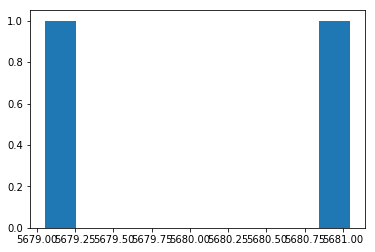

In [394]:
train_ar_params = optimize_ar(train, 3)

In [161]:
train_ar_params

(5679.055033817317, 1)

## Now let's try an AR models with differencing (ARI?)

In [162]:
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()
model_fit.aic

5696.590789915786

Model is worse with d at 1 or 2!

## Now let's try an ARIMA model

In [163]:
#I'm making p smaller to decrease compute time
aic_res_arima = []
for i in range(1,5):
    model = ARIMA(train, order=(1,0,i))
    model_fit = model.fit()
    #print(i, model_fit.aic)
    aic_res_arima.append(model_fit.aic)

In [164]:
np.array(aic_res_arima).argmin()

0

In [165]:
aic_res_arima

[5681.04385159504, 5682.306080164076, 5682.81581270908, 5683.967103889868]

MA also don't help, keep Q=0

Seems like my best model is (p,d,q) = (1,0,0) so far with an AIC of 5679.

## Let's try predicting things

In [166]:
best_model_so_far = ARIMA(train, order=(1,0,0))
best_model_so_far = model.fit()

In [167]:
best_model_so_far.aic

5683.967103889868

In [168]:
validation['preds'] = best_model_so_far.predict(weekly_vix.shape[0]-52*4, weekly_vix.shape[0]-52*2, dynamic=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [169]:
%autoreload 2
from helper import RMSE
RMSE(validation.vix_close.values,validation.preds.values)

5.213854632027064

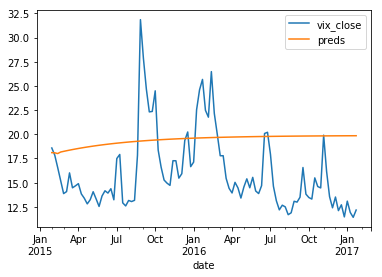

In [170]:
validation[['vix_close','preds']].plot()
#validation.plot('vix_close','preds')

## Reoptimize with RMSE as scoring param

In [171]:
from helper import optimize_ar_rmse

/Users/nmp256/Code/datascience/metis/luther/helper.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  val['preds'] = model_fit.predict(tot.shape[0]-52*4, tot.shape[0]-52*2, dynamic=False)


(5.21340806204691, 2)

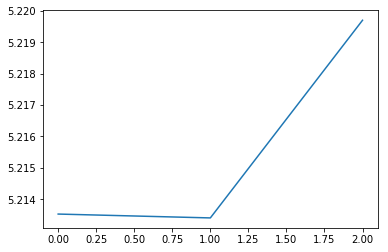

In [172]:
optimize_ar_rmse(train,validation,weekly_vix,4)

In [173]:
from helper import plot_preds

/Users/nmp256/Code/datascience/metis/luther/helper.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  val['preds'] = model_fit.predict(tot.shape[0]-52*4, tot.shape[0]-52*2, dynamic=False)


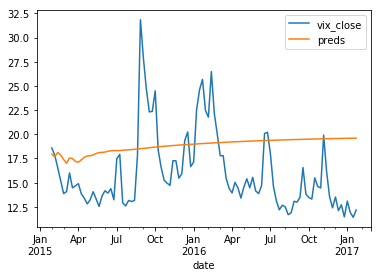

In [174]:
plot_preds(train,validation,weekly_vix)

## Too good to be true with fitting on whole model

In [42]:
old_working_model = ARIMA(weekly_vix,order=(1,0,0))
old_working_model = old_working_model.fit()
old_working_model.aic

ValueError: could not broadcast input array from shape (2) into shape (1)

In [26]:
weekly_vix.shape

(1516, 1)

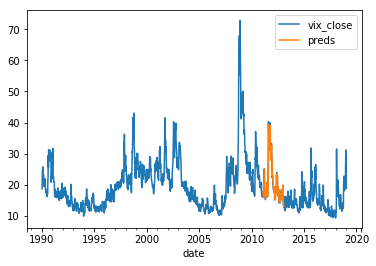

In [27]:
weekly_vix['preds'] = old_working_model.predict(start = weekly_vix.shape[0]-52*8, end= weekly_vix.shape[0]-52*6, dynamic=False)
weekly_vix[['vix_close','preds']].plot();

In [28]:
weekly_preds = weekly_vix.iloc[weekly_vix.shape[0]-52*8:weekly_vix.shape[0]-52*6]

In [29]:
weekly_preds.head()

,vix_close,preds
date,,
2011-02-06,17.4160,17.682786
2011-02-13,15.9480,17.493050
2011-02-20,16.4120,16.086319
2011-02-27,20.8675,16.530954
2011-03-06,19.5440,20.800497


5.213854632027064

5.213854632027064

## SARIMA test

In [325]:
import statsmodels.api as sm

In [176]:
train.head()

,vix_close
date,
1990-01-07,18.690
1990-01-14,21.918
1990-01-21,24.304
1990-01-28,25.744
1990-02-04,25.648


In [335]:
sar = sm.tsa.statespace.SARIMAX(train, order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()
sar.aic

5898.6855490976795

In [336]:
pred = sar.get_prediction(weekly_vix.shape[0]-52*4,weekly_vix.shape[0]-52*2)

In [337]:
validation['preds'] = pred.predicted_mean

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [338]:
RMSE(validation.vix_close.values,validation.preds.values)

6.054353058752897

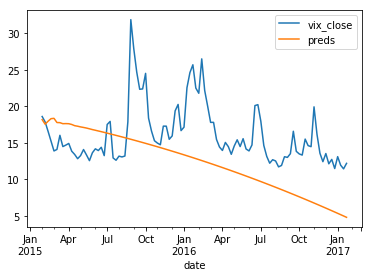

In [339]:
validation[['vix_close','preds']].plot()

## Include Exogenous variables

In [376]:
train, validation, test = split_data(vp_df,12)

In [378]:
sar = sm.tsa.statespace.SARIMAX(train['vix_close'],exog=train['prime_rate'], order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [379]:
sar.aic

1704.9439019279675

In [385]:
exog_forecast = validation.loc[:,['prime_rate']]

In [386]:
pred = sar.get_prediction(vp_df.shape[0]-12*4,vp_df.shape[0]-12*2-1,exog=exog_forecast)

In [387]:
validation['preds'] = pred.predicted_mean

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [388]:
RMSE(validation.vix_close.values,validation.preds.values)

21.77932487352954

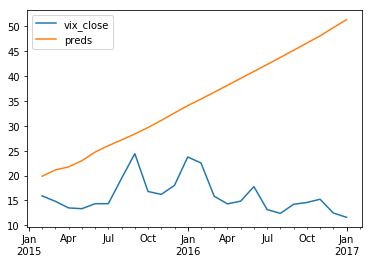

In [389]:
validation[['vix_close','preds']].plot()

## Facebook Prophet

In [88]:
from fbprophet import Prophet

In [96]:
p_train = train
p_train.columns = ['y']
p_train['ds']= p_train.index


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,y,ds
date,,
1990-01-07,18.690,1990-01-07
1990-01-14,21.918,1990-01-14
1990-01-21,24.304,1990-01-21
1990-01-28,25.744,1990-01-28
1990-02-04,25.648,1990-02-04


In [115]:
p_validation.head()

,vix_close,ds
date,,
2015-02-01,18.582,2015-02-01
2015-02-08,17.846,2015-02-08
2015-02-15,16.554,2015-02-15
2015-02-22,15.210,2015-02-22
2015-03-01,13.868,2015-03-01


In [116]:
p_validation = validation
p_validation = p_validation.drop('preds',axis=1)
p_validation.columns = ['y','ds']
p_validation['ds']=p_validation.index

In [117]:
m = Prophet()
m.fit(p_train)
#future = m.make_future_dataframe(periods=213)
forecast = m.predict(p_validation)
#m.plot_components(forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


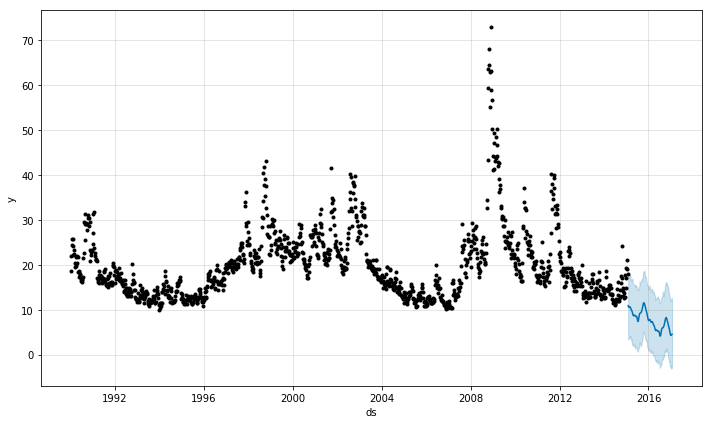

In [118]:
fig1 = m.plot(forecast)

In [119]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [120]:
forecast['mean'] = (forecast['yhat_lower'] + forecast['yhat_upper'])/2
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,mean
0,2015-02-01,10.970086,3.380528,18.124125,10.970086,10.970086,-0.061619,-0.061619,-0.061619,-0.061619,-0.061619,-0.061619,0.0,0.0,0.0,10.908467,10.752326
1,2015-02-08,10.906807,3.819001,17.566810,10.906807,10.906807,-0.278850,-0.278850,-0.278850,-0.278850,-0.278850,-0.278850,0.0,0.0,0.0,10.627957,10.692905
2,2015-02-15,10.843527,3.618874,16.971668,10.843527,10.843527,-0.342399,-0.342399,-0.342399,-0.342399,-0.342399,-0.342399,0.0,0.0,0.0,10.501128,10.295271
3,2015-02-22,10.780247,3.544038,17.452494,10.780247,10.780247,-0.211406,-0.211406,-0.211406,-0.211406,-0.211406,-0.211406,0.0,0.0,0.0,10.568841,10.498266
4,2015-03-01,10.716968,3.706893,17.509004,10.716968,10.716968,-0.060761,-0.060761,-0.060761,-0.060761,-0.060761,-0.060761,0.0,0.0,0.0,10.656207,10.607949


In [125]:
p_validation['preds']=forecast['yhat']

In [126]:
p_validation.head()

,y,ds,preds
date,,,
2015-02-01,18.582,2015-02-01,NaN
2015-02-08,17.846,2015-02-08,NaN
2015-02-15,16.554,2015-02-15,NaN
2015-02-22,15.210,2015-02-22,NaN
2015-03-01,13.868,2015-03-01,NaN


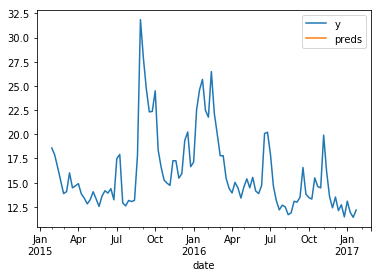

In [123]:
p_validation[['y','preds']].plot()